In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates

import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [ ]:

#ds_sip_mc3e = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/cams_ccn/mc3e_2moment/NWP_LAM_icongrid*.nc');

ds_sip = xr.open_mfdataset('/work/bb1163/b382718/output/mc3e/nested_run/icon_output/continental_ccn/light_param/SIP/iic_phillips/mc3e_2mom_sip/NWP_LAM_icongrid_DOM04_20110511*Z.nc');
ds_nosip = xr.open_mfdataset('/work/bb1163/b382718/output/mc3e/nested_run/icon_output/continental_ccn/light_param/SIP/mc3e_2mom_nosip/NWP_LAM_icongrid_DOM04_20110511*Z.nc');


In [3]:

ds_sip['w_vel'] = -1.*ds_sip.omega/(9.8*ds_sip.rho)
ds_sip['tempc'] = ds_sip.temp-273.16;
ds_sip['lwc_gperm3']  = ds_sip.qc*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['ciwc_gperm3'] = ds_sip.qi*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['tiwc_gperm3'] = (ds_sip.qi+ds_sip.qs+ds_sip.qg+ds_sip.qh)*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['cdnc_percm3'] = ds_sip.qnc*ds_sip.rho*1.e-6  # perkg to percm3
ds_sip['inc_perl'] = (ds_sip.qni+ds_sip.qns+ds_sip.qng+ds_sip.qnh)*ds_sip.rho*1.e-3 # perkg to perl

ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

In [4]:

grid_mc3e = xr.open_dataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/cams_ccn/mc3e_2moment/domain4_DOM04.nc');

clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-98., 37.])
okla_x, okla_y = np.array([-98., 37.])
#print(okla_x), print(okla_y)
dx_deg = 1.; dy_deg = 1.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


-100.03562402798536
-93.96330271276062
31.965389663179398
38.035332298302436
-99.0
-97.0
38.0
36.0


(None, None)

In [5]:

window_cell = (
    (grid_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_mc3e.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_mc3e.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_mc3e = reindex_grid(grid_mc3e, selected_indices, vars_to_renumber)

mask=np.isin(ds_sip['ncells'], selected_indices.cell)


window_vertex_indices :: [   23    67   148 ... 62065 62069 62074]
window_edge_indices :: [   699   1112   1135 ... 175964 175965 175966]


In [6]:

aircraft_starttime='2011-05-11T16:30:00.000000000'
aircraft_endtime='2011-05-11T21:00:00.000000000'

ds_sip_new = ds_sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [100]:
#print(nice_cip_perm3.shape)
#print(data_v2_new)
print(data_v2_new.shape)
filtered_data_v2 = data_v2[data_v2['time'].isin(data_cip['time'])]
print(filtered_data_v2.shape)
print(data_v2.time)
print(data_cip.time)

(13267, 67)
(13267, 45)
0        56772
1        56773
2        56774
3        56775
4        56776
         ...  
13262    70071
13263    70072
13264    70073
13265    70074
13266    70075
Name: time, Length: 13267, dtype: int64
0        56772
1        56773
2        56774
3        56775
4        56776
         ...  
13300    70072
13301    70073
13302    70074
13303    70075
13304    70076
Name: time, Length: 13305, dtype: int64


In [7]:


w_thres = 2.
###### Without SIP
# lwc gperm3
filt_lwc_up_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
filt_lwc_dn_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
filt_lwc_st_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

lwc_up_nosip = filt_lwc_up_perl.mean(dim=('time','ncells'))
lwc_dn_nosip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
lwc_st_nosip = filt_lwc_st_perl.mean(dim=('time','ncells'))

tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
filt_tiwc_st_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

tiwc_up_nosip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
tiwc_dn_nosip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
tiwc_st_nosip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
filt_cdnc_dn_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
filt_cdnc_st_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

cdnc_up_nosip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
cdnc_dn_nosip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
cdnc_st_nosip = filt_cdnc_st_perl.mean(dim=('time','ncells'))

# inc gperm3
filt_inc_up_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
filt_inc_dn_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
filt_inc_st_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

inc_up_nosip = filt_inc_up_perl.mean(dim=('time','ncells'))
inc_dn_nosip = filt_inc_dn_perl.mean(dim=('time','ncells'))
inc_st_nosip = filt_inc_st_perl.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up_perl = xr.where((ds_sip_new.lwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.lwc_gperm3, np.nan)
filt_lwc_dn_perl = xr.where((ds_sip_new.lwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.lwc_gperm3, np.nan)
filt_lwc_st_perl = xr.where((ds_sip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up_perl.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st_perl.mean(dim=('time','ncells'))

tempc_sip = ds_sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up_perl = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn_perl = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st_perl = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up_perl = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn_perl = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.cdnc_percm3, np.nan)
filt_cdnc_st_perl = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st_perl.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up_perl = xr.where((ds_sip_new.inc_perl > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.inc_perl, np.nan)
filt_inc_dn_perl = xr.where((ds_sip_new.inc_perl > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.inc_perl, np.nan)
filt_inc_st_perl = xr.where((ds_sip_new.inc_perl > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up_perl.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn_perl.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st_perl.mean(dim=('time','ncells'))

In [166]:
data_hvps

,time,Nt_perm3,iwc_gperm3,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,...,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4,Nt_perm4
0,56774,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,...,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30
1,56775,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,...,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30
2,56776,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,...,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30
3,56777,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,...,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30
4,56778,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,...,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30,9.990000e+30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12796,69570,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12797,69571,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12798,69572,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
12799,69573,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [27]:
data_cip.iwc_gperm3

0        9.990000e+30
1        9.990000e+30
2        9.990000e+30
3        9.990000e+30
4        9.990000e+30
             ...     
13300    9.990000e+30
13301    9.990000e+30
13302    9.990000e+30
13303    9.990000e+30
13304    9.990000e+30
Name: iwc_gperm3, Length: 13305, dtype: float64

In [28]:
import pandas as pd
import numpy as np

# CIP
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/20110511_154612.CIP.1Hz'
data_cip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=40)

data_cip.columns = ['time','Nt_perm3','iwc_gperm3']+ ['Nt_perm4'] * (data_cip.shape[1] - 3)

# HVPS
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/20110511_154612.HVPS3.1Hz'
data_hvps = pd.read_csv(file_path, sep='\s+', header=None, skiprows=40)

data_hvps.columns = ['time','Nt_perm3','iwc_gperm3']+ ['Nt_perm4'] * (data_hvps.shape[1] - 3)

# Flight data
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/2011_05_11_15_46_09_v2.mc3e'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=63)

data_v2.columns = ['time', 'air_temp', 'machno', 'ias', 'tas', 
                   'pres_alt', 'pot_temp', 'pitot_wing', 'cabin_pres', 'static_pr',
                   'dewpt', 'mix_ratio', 'dew_point', 'frost_point', 'pos_roll', 
                   'pos_pitch', 'pos_head', 'posz_acc', 'pos_lat', 'pos_lon',
                   'pos_alt', 'pos_spd', 'pos_trk', 'alpha', 'beta', 
                   'wind_z', 'vert_vel', 'wind_m', 'wind_d', 'turb',
                   'lwc_king', 'twc_nev', 'lwc_nev', 'conc_cdp', 'lwc_cdp', 
                   'cdp_meanD', 'cdp_volD', 'cdp_effrad', 'conc_2dc', '2dc_meanD',
                   '2dc_volD', '2dc_effrad', 'icemsofreq', 'cpc_conc', 'tsg_gate']

data_v2['time'] = data_v2['time'].astype(int)
# sum cip concentration over all diameter bins

diam_cip_end_bin  = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 
                     475.0, 550.0, 625.0, 700.0, 800.0, 900.0, 1000.0, 1200.0,
                     1400.0, 1600.0, 1800.0, 2000.0];

diam_hvps_end_bin = [200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0,
                    2200.0, 2600.0, 3000.0, 3400.0, 3800.0, 4200.0, 4600.0, 5000.0, 6000.0,  
                    7000.0, 8000.0, 9000.0, 10000.0, 12000.0, 14000.0, 16000.0, 18000.0,
                    20000.0, 25000.0, 30000.0]

diam_cip_width = np.diff(diam_cip_end_bin)*1.e-6 # µm to m
diam_hvps_width = np.diff(diam_hvps_end_bin)*1.e-6 # µm to m

print(diam_cip_width.shape, diam_hvps_width.shape)

## TINC
nt_cip_perm4 = data_cip.iloc[:, 3:].values
nt_hvps_perm4 = data_hvps.iloc[:, 3:].values

cip_mask = (nt_cip_perm4 != 9.99e+30) & (nt_cip_perm4 != 0.0)
hvps_mask = (nt_hvps_perm4 != 9.99e+30) & (nt_hvps_perm4 != 0.0)
#nice_perm3 = np.where(cip_mask & (diam_cip_end_bin[:-1] > 2.e-4), nt_perm4 * diam_cip_width, 0)

nice_cip_perm3 = np.where(cip_mask, nt_cip_perm4 * diam_cip_width, np.nan)  # basically considering all particles from 50 to 2000 µm
nice_hvps_perm3 = np.where(hvps_mask, nt_hvps_perm4 * diam_hvps_width, np.nan)  # basically considering all particles from 200 to 30000 µm

nice_cip_perm3 = np.nansum(nice_cip_perm3, axis=1)
nice_hvps_perm3 = np.nansum(nice_hvps_perm3, axis=1)
#valid_rows = np.any(cip_mask, axis=1)
#valid_times = data_cip.loc[valid_rows, 'time']
#print(valid_times.values)
##non_zero_values = nice_perm3[nice_perm3 != 0.]
#non_nan_values = nice_perm3[~np.isnan(nice_perm3)]
#print(non_nan_values)

# IWC
iwc_cip_gperm3 = data_cip.iwc_gperm3
iwc_hvps_gperm3 = data_hvps.iwc_gperm3

cip_mask = (iwc_cip_gperm3 != 9.99e+30) & (iwc_cip_gperm3 != 0.0)
hvps_mask = (iwc_hvps_gperm3 != 9.99e+30) & (iwc_hvps_gperm3 != 0.0)

iwc_cip_gperm3 = np.where(cip_mask, iwc_cip_gperm3, np.nan)  
iwc_hvps_gperm3 = np.where(hvps_mask, iwc_hvps_gperm3, np.nan)  



data_cip['nice_cip_perm3'] = nice_cip_perm3
data_cip['nice_cip_perl'] = 1.e-3*nice_cip_perm3

data_hvps['nice_hvps_perm3'] = nice_hvps_perm3
data_hvps['nice_hvps_perl'] = 1.e-3*nice_hvps_perm3

data_cip['iwc_cip_gperm3'] = iwc_cip_gperm3
data_hvps['iwc_hvps_gperm3'] = iwc_hvps_gperm3


data_cip_new = data_cip.drop(columns=['Nt_perm4'])  # no need of 19 (conc in each bin) columns, drop it
data_hvps_new = data_hvps.drop(columns=['Nt_perm4'])  # no need of 19 (conc in each bin) columns, drop it 

data_cip_new = data_cip.drop(columns=['iwc_gperm3'])  
data_hvps_new = data_hvps.drop(columns=['iwc_gperm3'])

ds_v2_cip_comb = pd.merge(data_v2, data_cip_new, on='time', how='inner')
ds_v2_hvps_comb = pd.merge(data_v2, data_hvps_new, on='time', how='inner')

# TINC
ds_v2_cip_comb['nice_cip_up_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (ds_v2_cip_comb.vert_vel > 2.), ds_v2_cip_comb.nice_cip_perl, np.nan)
ds_v2_cip_comb['nice_cip_dn_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (ds_v2_cip_comb.vert_vel < -2.), ds_v2_cip_comb.nice_cip_perl, np.nan)
ds_v2_cip_comb['nice_cip_st_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), ds_v2_cip_comb.nice_cip_perl, np.nan)

ds_v2_hvps_comb['nice_hvps_up_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (ds_v2_hvps_comb.vert_vel > 2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)
ds_v2_hvps_comb['nice_hvps_dn_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (ds_v2_hvps_comb.vert_vel < -2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)
ds_v2_hvps_comb['nice_hvps_st_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)

# IWC
ds_v2_cip_comb['iwc_cip_up_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (ds_v2_cip_comb.vert_vel > 2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)
ds_v2_cip_comb['iwc_cip_dn_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (ds_v2_cip_comb.vert_vel < -2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)
ds_v2_cip_comb['iwc_cip_st_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)

ds_v2_hvps_comb['iwc_hvps_up_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (ds_v2_hvps_comb.vert_vel > 2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)
ds_v2_hvps_comb['iwc_hvps_dn_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (ds_v2_hvps_comb.vert_vel < -2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)
ds_v2_hvps_comb['iwc_hvps_st_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)

# CDNC
ds_v2_hvps_comb['cdnc_cdp_up_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (ds_v2_hvps_comb.vert_vel > 2.), ds_v2_hvps_comb.conc_cdp, np.nan)
ds_v2_hvps_comb['cdnc_cdp_dn_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (ds_v2_hvps_comb.vert_vel < -2.), ds_v2_hvps_comb.conc_cdp, np.nan)
ds_v2_hvps_comb['cdnc_cdp_st_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), ds_v2_hvps_comb.conc_cdp, np.nan)

# LWC
ds_v2_hvps_comb['lwc_cdp_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)
ds_v2_hvps_comb['lwc_cdp_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)
ds_v2_hvps_comb['lwc_cdp_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)

ds_v2_hvps_comb['lwc_king_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)
ds_v2_hvps_comb['lwc_king_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)
ds_v2_hvps_comb['lwc_king_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)

ds_v2_hvps_comb['lwc_nev_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)
ds_v2_hvps_comb['lwc_nev_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)
ds_v2_hvps_comb['lwc_nev_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)


# make a plot using seaborn
#temp_bin = np.array([0., -4., -8., -12., -16., -20., -24., -28., -32.])
#temp_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_bin = np.arange(-30, 30, 3)
temp_bin = np.sort(temp_bin)

temp_cdp_bin = np.arange(-30, 30, 4)
temp_cdp_bin = np.sort(temp_cdp_bin)


ds_v2_cip_comb['temp_bin'] = pd.cut(ds_v2_cip_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)

# Merge temperature bins into CIP dataset
ds_v2_cip_comb = ds_v2_cip_comb.copy()
#data_cip_new['temp_bin'] = data_v2_new['temp_bin'].values

# Remove NaN values (cases where no temperature bin was assigned)
ds_v2_cip_comb = ds_v2_cip_comb.dropna(subset=['temp_bin'])
ds_v2_hvps_comb = ds_v2_hvps_comb.dropna(subset=['temp_bin'])

# Convert bin labels to numeric for proper sorting
ds_v2_cip_comb['temp_bin'] = ds_v2_cip_comb['temp_bin'].astype(float)
ds_v2_hvps_comb['temp_bin'] = ds_v2_hvps_comb['temp_bin'].astype(float)


(19,) (28,)


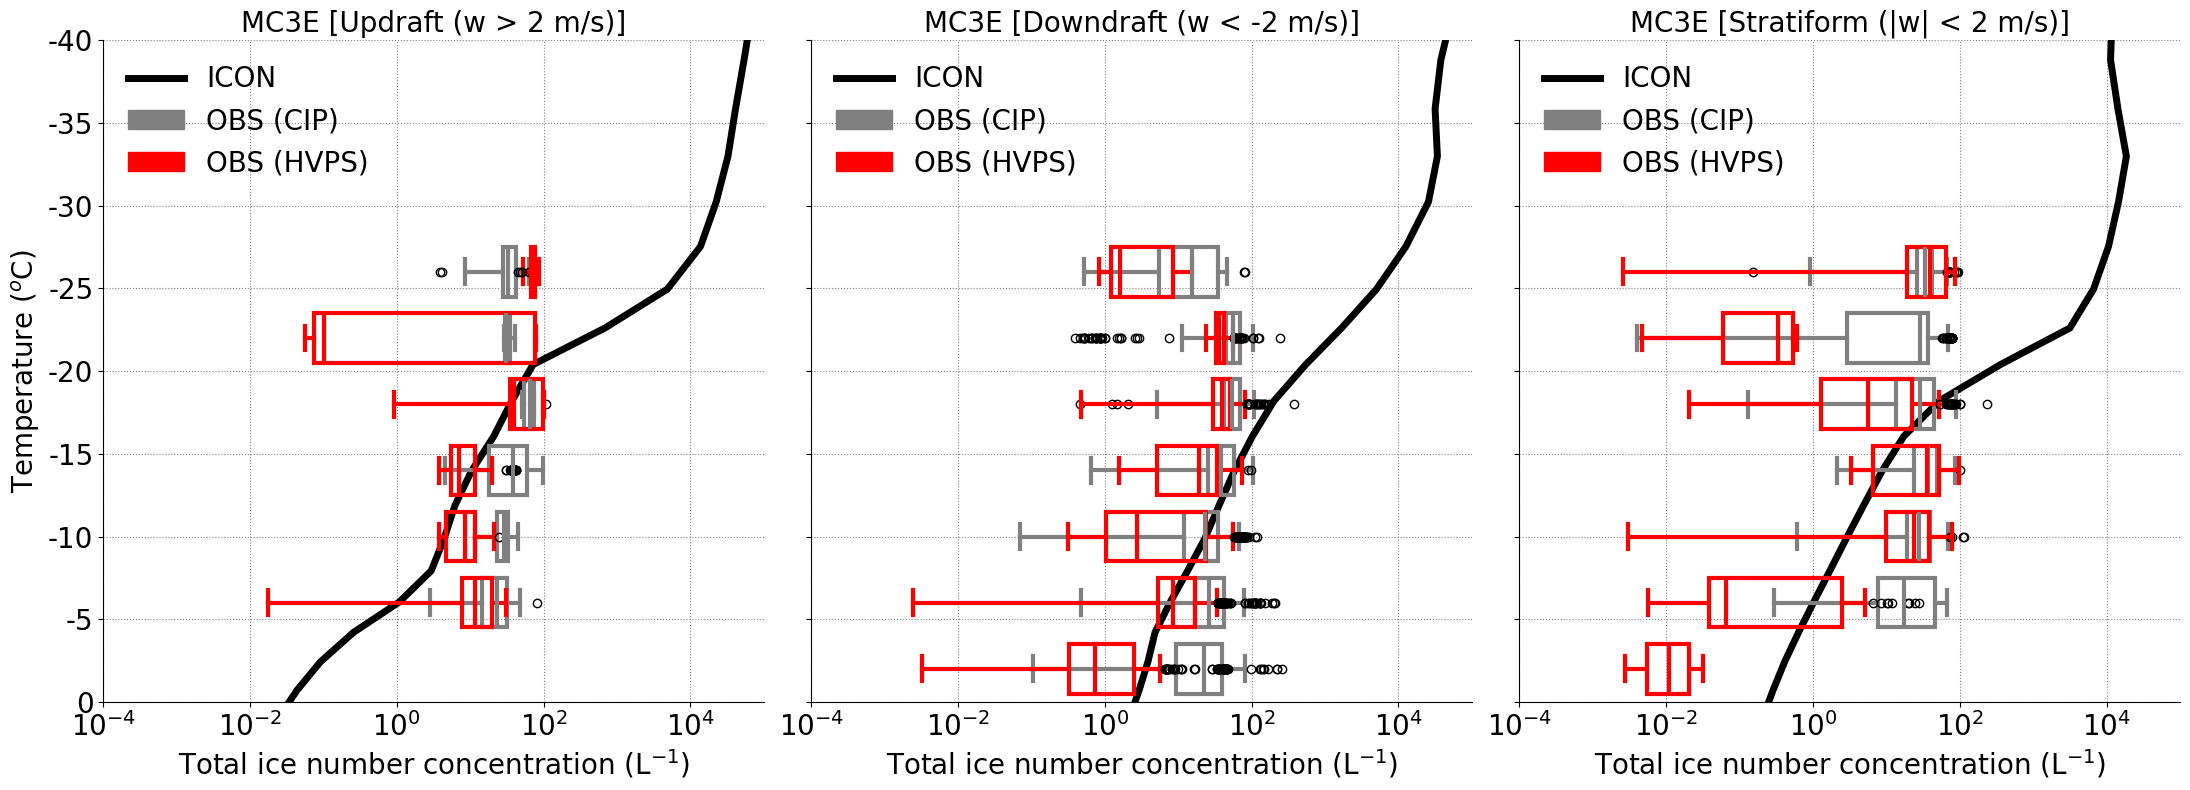

In [30]:

# CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)
df_v2_cip_comb['tempc'] = df_v2_cip_comb['air_temp']

#temp_cip_bin = np.arange(df_v2_cip_comb['tempc'].min() - 2, df_v2_cip_comb['tempc'].max() + 2, 3)  

temp_cip_bin = np.arange(-30, 3, 4)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_cip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_cip_bin']]

# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

temp_hvps_bin = np.arange(-30, 3, 4)
temp_hvps_bin = np.sort(temp_hvps_bin)
df_v2_hvps_comb['temp_hvps_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_hvps_bin, right=False)

bin_edges = np.concatenate([temp_hvps_bin - 2, [temp_hvps_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_hvps_bin']]


### TINC
# CIP
df_nice_up_cip = df_v2_cip_comb[['nice_cip_up_perl', 'temp_bin']].dropna()
df_nice_dn_cip = df_v2_cip_comb[['nice_cip_dn_perl', 'temp_bin']].dropna()
df_nice_st_cip = df_v2_cip_comb[['nice_cip_st_perl', 'temp_bin']].dropna()

df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
df_nice_dn_cip = df_nice_dn_cip.dropna(subset=['temp_bin'])
df_nice_st_cip = df_nice_st_cip.dropna(subset=['temp_bin'])

nice_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['nice_cip_up_perl'].values for temp in bin_edges]
nice_cip_dn_by_bin = [df_nice_dn_cip[df_nice_dn_cip['temp_bin'] == temp]['nice_cip_dn_perl'].values for temp in bin_edges]
nice_cip_st_by_bin = [df_nice_st_cip[df_nice_st_cip['temp_bin'] == temp]['nice_cip_st_perl'].values for temp in bin_edges]

# HVPS
df_nice_up_hvps = df_v2_hvps_comb[['nice_hvps_up_perl', 'temp_bin']].dropna()
df_nice_dn_hvps = df_v2_hvps_comb[['nice_hvps_dn_perl', 'temp_bin']].dropna()
df_nice_st_hvps = df_v2_hvps_comb[['nice_hvps_st_perl', 'temp_bin']].dropna()

df_nice_up_hvps = df_nice_up_hvps.dropna(subset=['temp_bin'])
df_nice_dn_hvps = df_nice_dn_hvps.dropna(subset=['temp_bin'])
df_nice_st_hvps = df_nice_st_hvps.dropna(subset=['temp_bin'])

nice_hvps_up_by_bin = [df_nice_up_hvps[df_nice_up_hvps['temp_bin'] == temp]['nice_hvps_up_perl'].values for temp in bin_edges]
nice_hvps_dn_by_bin = [df_nice_dn_hvps[df_nice_dn_hvps['temp_bin'] == temp]['nice_hvps_dn_perl'].values for temp in bin_edges]
nice_hvps_st_by_bin = [df_nice_st_hvps[df_nice_st_hvps['temp_bin'] == temp]['nice_hvps_st_perl'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']
#data_list = [nice_up_by_bin, nice_dn_by_bin, nice_st_by_bin]
#temp_bins_list = [temp_cip_bin, temp_cip_bin, temp_cip_bin]

fontsize = 20;
linewidth = 3;
width=3;
alpha=1;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(nice_hvps_up_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 1:
        ax.plot(inc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(nice_hvps_dn_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 2:
        ax.plot(inc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(nice_hvps_st_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e5)
    ax.set_ylim(0, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (CIP)')
    obs_hvps_patch = mpatches.Patch(color='red', label='OBS (HVPS)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch, obs_hvps_patch], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

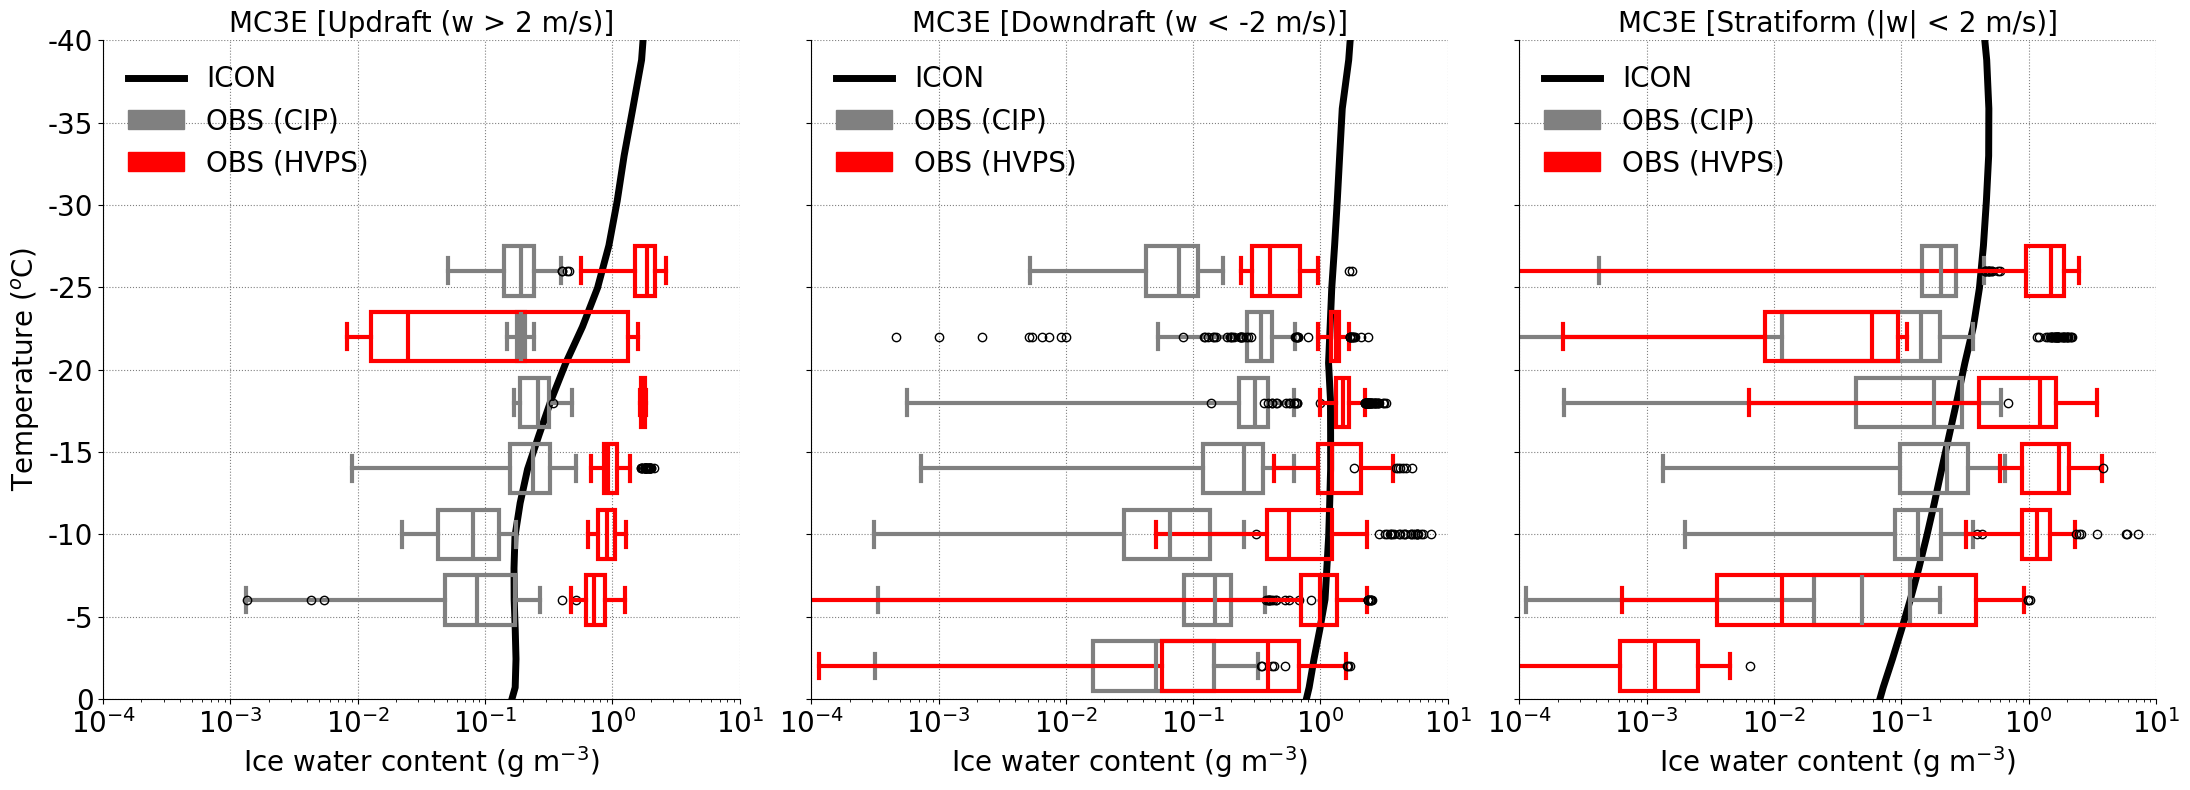

In [32]:

## IWC
# CIP
df_iwc_up_cip = df_v2_cip_comb[['iwc_cip_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_cip = df_v2_cip_comb[['iwc_cip_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_cip = df_v2_cip_comb[['iwc_cip_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_cip = df_iwc_up_cip.dropna(subset=['temp_bin'])
df_iwc_dn_cip = df_iwc_dn_cip.dropna(subset=['temp_bin'])
df_iwc_st_cip = df_iwc_st_cip.dropna(subset=['temp_bin'])

iwc_cip_up_by_bin = [df_iwc_up_cip[df_iwc_up_cip['temp_bin'] == temp]['iwc_cip_up_gperm3'].values for temp in bin_edges]
iwc_cip_dn_by_bin = [df_iwc_dn_cip[df_iwc_dn_cip['temp_bin'] == temp]['iwc_cip_dn_gperm3'].values for temp in bin_edges]
iwc_cip_st_by_bin = [df_iwc_st_cip[df_iwc_st_cip['temp_bin'] == temp]['iwc_cip_st_gperm3'].values for temp in bin_edges]

# HVPS
df_iwc_up_hvps = df_v2_hvps_comb[['iwc_hvps_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_hvps = df_v2_hvps_comb[['iwc_hvps_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_hvps = df_v2_hvps_comb[['iwc_hvps_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_hvps = df_iwc_up_hvps.dropna(subset=['temp_bin'])
df_iwc_dn_hvps = df_iwc_dn_hvps.dropna(subset=['temp_bin'])
df_iwc_st_hvps = df_iwc_st_hvps.dropna(subset=['temp_bin'])

iwc_hvps_up_by_bin = [df_iwc_up_hvps[df_iwc_up_hvps['temp_bin'] == temp]['iwc_hvps_up_gperm3'].values for temp in bin_edges]
iwc_hvps_dn_by_bin = [df_iwc_dn_hvps[df_iwc_dn_hvps['temp_bin'] == temp]['iwc_hvps_dn_gperm3'].values for temp in bin_edges]
iwc_hvps_st_by_bin = [df_iwc_st_hvps[df_iwc_st_hvps['temp_bin'] == temp]['iwc_hvps_st_gperm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']
#data_list = [nice_up_by_bin, nice_dn_by_bin, nice_st_by_bin]
#temp_bins_list = [temp_cip_bin, temp_cip_bin, temp_cip_bin]

fontsize = 20;
linewidth = 3;
width=3;
alpha=1;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(tiwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(iwc_hvps_up_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 1:
        ax.plot(tiwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(iwc_hvps_dn_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 2:
        ax.plot(tiwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
        ax.boxplot(iwc_hvps_st_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e1)
    ax.set_ylim(0, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (CIP)')
    obs_hvps_patch = mpatches.Patch(color='red', label='OBS (HVPS)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3650129/4159639975.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3], fontsize=fontsize)
/tmp/ipykernel_3650129/4159639975.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3], fontsize=fontsize)
/tmp/ipykernel_3650129/4159639975.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3], fontsize=fontsize)


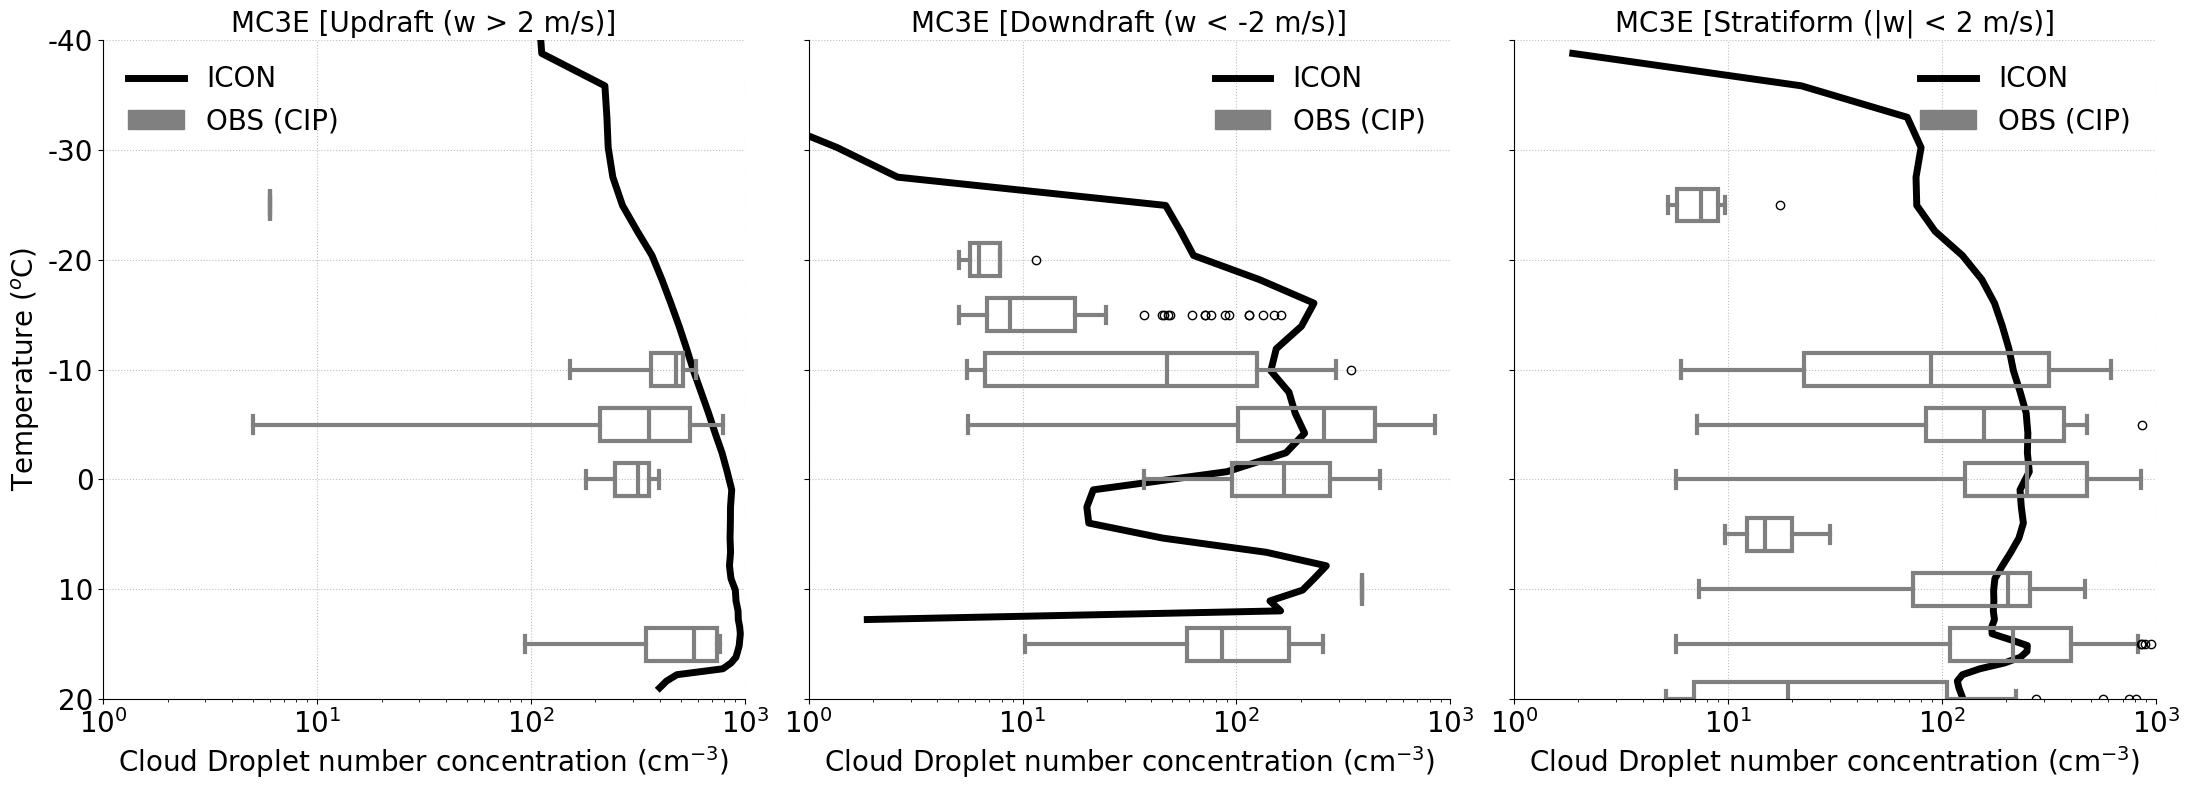

In [21]:

# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)
df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]

# CDNC
df_cdnc_up_cdp = df_v2_hvps_comb[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_dn_cdp = df_v2_hvps_comb[['cdnc_cdp_dn_percm3', 'temp_bin']].dropna()
df_cdnc_st_cdp = df_v2_hvps_comb[['cdnc_cdp_st_percm3', 'temp_bin']].dropna()

df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
df_cdnc_dn_cdp = df_cdnc_dn_cdp.dropna(subset=['temp_bin'])
df_cdnc_st_cdp = df_cdnc_st_cdp.dropna(subset=['temp_bin'])

cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]
cdnc_cdp_dn_by_bin = [df_cdnc_dn_cdp[df_cdnc_dn_cdp['temp_bin'] == temp]['cdnc_cdp_dn_percm3'].values for temp in bin_edges]
cdnc_cdp_st_by_bin = [df_cdnc_st_cdp[df_cdnc_st_cdp['temp_bin'] == temp]['cdnc_cdp_st_percm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
alpha=1.0
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    elif i == 1:
        ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    elif i == 2:
        ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e0, 1.e3)
    ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3], fontsize=fontsize)
    ax.set_ylim(20, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud Droplet number concentration (cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=0.5)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch = mpatches.Patch(color='grey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3650129/838028674.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3650129/838028674.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3650129/838028674.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)


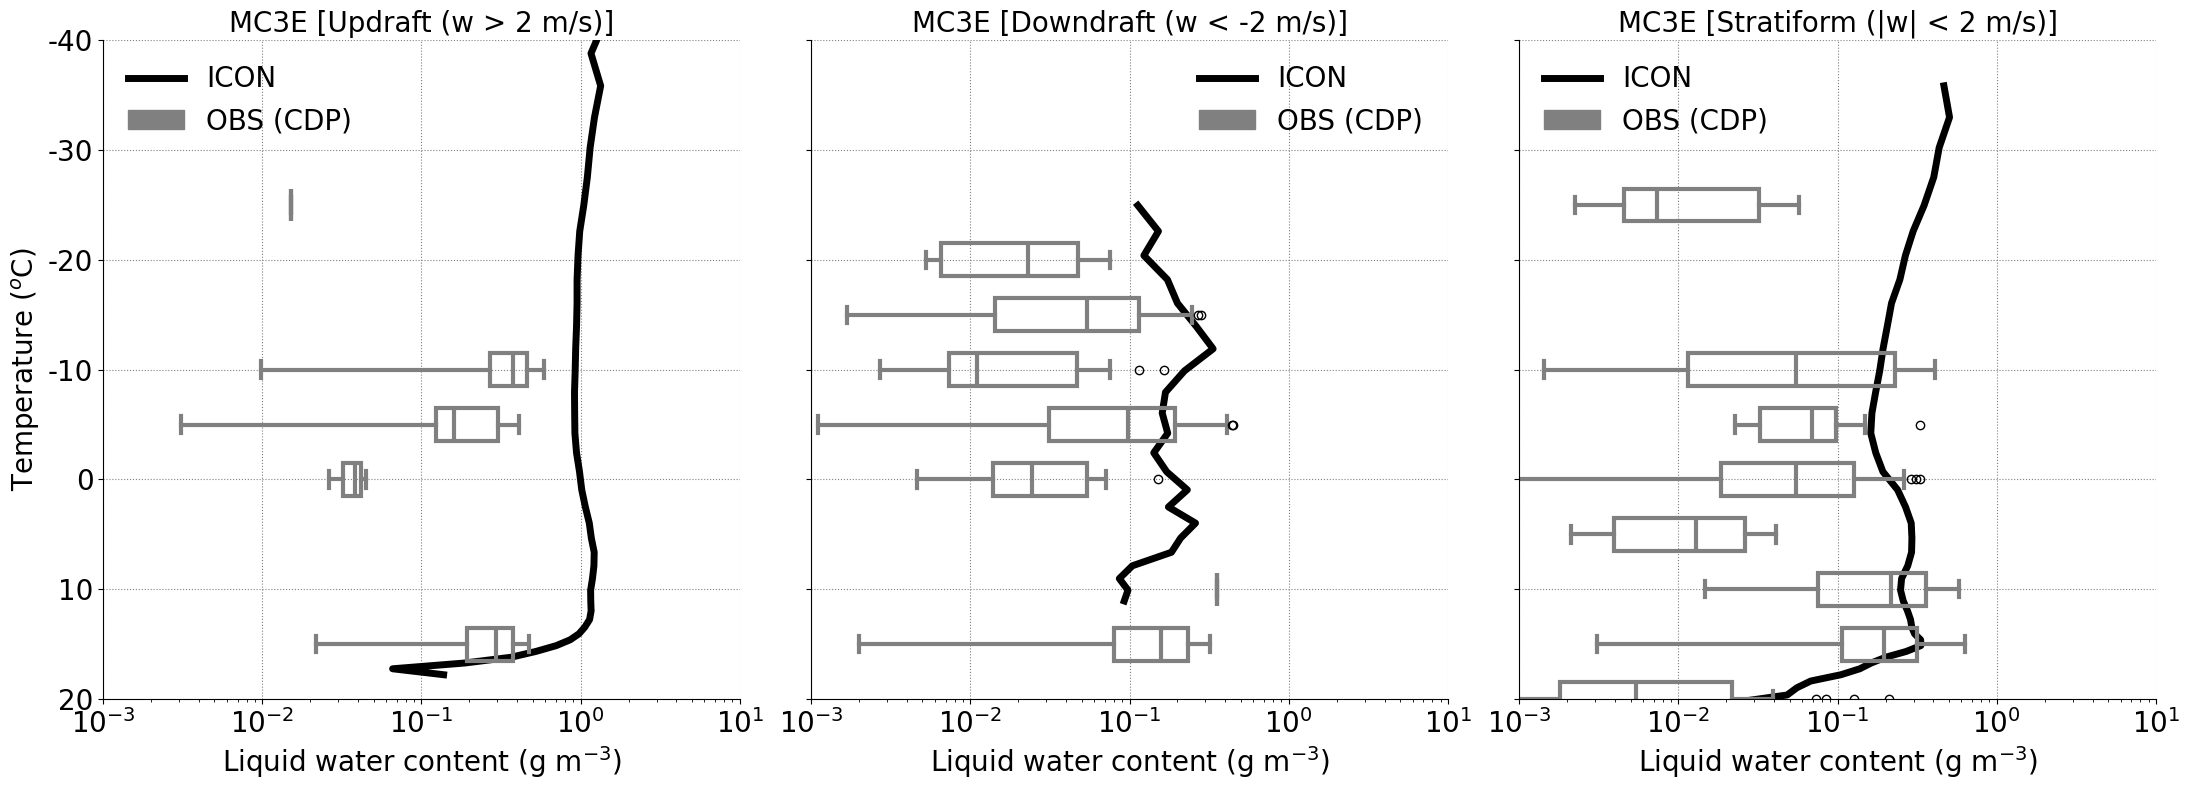

In [15]:


# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)
df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]

# LWC-CDP
df_lwc_up_cdp = df_v2_hvps_comb[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_cdp = df_v2_hvps_comb[['lwc_cdp_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_cdp = df_v2_hvps_comb[['lwc_cdp_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
df_lwc_dn_cdp = df_lwc_dn_cdp.dropna(subset=['temp_bin'])
df_lwc_st_cdp = df_lwc_st_cdp.dropna(subset=['temp_bin'])

lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]
lwc_cdp_dn_by_bin = [df_lwc_dn_cdp[df_lwc_dn_cdp['temp_bin'] == temp]['lwc_cdp_dn_gperm3'].values for temp in bin_edges]
lwc_cdp_st_by_bin = [df_lwc_st_cdp[df_lwc_st_cdp['temp_bin'] == temp]['lwc_cdp_st_gperm3'].values for temp in bin_edges]


# LWC-KING
df_lwc_up_king = df_v2_hvps_comb[['lwc_king_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_king = df_v2_hvps_comb[['lwc_king_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_king = df_v2_hvps_comb[['lwc_king_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_king = df_lwc_up_king.dropna(subset=['temp_bin'])
df_lwc_dn_king = df_lwc_dn_king.dropna(subset=['temp_bin'])
df_lwc_st_king = df_lwc_st_king.dropna(subset=['temp_bin'])

lwc_king_up_by_bin = [df_lwc_up_king[df_lwc_up_king['temp_bin'] == temp]['lwc_king_up_gperm3'].values for temp in bin_edges]
lwc_king_dn_by_bin = [df_lwc_dn_king[df_lwc_dn_king['temp_bin'] == temp]['lwc_king_dn_gperm3'].values for temp in bin_edges]
lwc_king_st_by_bin = [df_lwc_st_king[df_lwc_st_king['temp_bin'] == temp]['lwc_king_st_gperm3'].values for temp in bin_edges]

# LWC-NEVZOROV
df_lwc_up_nev = df_v2_hvps_comb[['lwc_nev_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_nev = df_v2_hvps_comb[['lwc_nev_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_nev = df_v2_hvps_comb[['lwc_nev_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_nev = df_lwc_up_nev.dropna(subset=['temp_bin'])
df_lwc_dn_nev = df_lwc_dn_nev.dropna(subset=['temp_bin'])
df_lwc_st_nev = df_lwc_st_nev.dropna(subset=['temp_bin'])

lwc_nev_up_by_bin = [df_lwc_up_nev[df_lwc_up_nev['temp_bin'] == temp]['lwc_nev_up_gperm3'].values for temp in bin_edges]
lwc_nev_dn_by_bin = [df_lwc_dn_nev[df_lwc_dn_nev['temp_bin'] == temp]['lwc_nev_dn_gperm3'].values for temp in bin_edges]
lwc_nev_st_by_bin = [df_lwc_st_nev[df_lwc_st_nev['temp_bin'] == temp]['lwc_nev_st_gperm3'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
alpha=1.0
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    elif i == 2:
        ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-3, 1.e1)
    ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(20, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch = mpatches.Patch(color='grey', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()